In [1]:
import os
import re

from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
from time import sleep

from bot.core.exchange.http_api import ExchangeManager, BybitRestAPI
from bot.utils.files import load_tokens_from_file
from bot.utils.coinmarketcap import get_top_tokens
from bot.core.db.postgres_manager import DBManager
from bot.config.credentials import host, user, password, db_name

db_params = {'host': host, 'user': user, 'password': password, 'dbname': db_name}
db_manager = DBManager(db_params)

import pandas as pd
# pd.options.display.float_format = '{:.2f}'.format

import polars as pl
import polars_ols as pls

import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm

In [2]:
def sort_pairs(df: pl.DataFrame) -> pl.DataFrame:
    return df.with_columns([
        pl.when(pl.col("coin1") <= pl.col("coin2")).then(pl.col("coin1")).otherwise(pl.col("coin2")).alias("pair_min"),
        pl.when(pl.col("coin1") <= pl.col("coin2")).then(pl.col("coin2")).otherwise(pl.col("coin1")).alias("pair_max"),
    ]).drop('coin1', 'coin2').rename({'pair_min': 'coin1', 'pair_max': 'coin2'}).select('coin1', 'coin2', pl.exclude('coin1', 'coin2'))

In [3]:
# get_top_tokens(limit=1000, output_file='./bot/config/top_1000_tokens.txt')

#### Скачиваем данные с Bybit

In [4]:
async def get_data(symbol, interval, n_iters):
    df = await exc_manager.get_candles(symbol=symbol, interval=interval, n_iters=n_iters)
    df = df['bybit_linear'].sort_index()
    df['Returns'] = df['Close'].pct_change()
    df['Log_price'] = np.log(df['Close'] + 1)
    df['Log_returns'] = np.log(df['Close']/df['Close'].shift(1))
    return df.dropna()

In [5]:
exc_manager = ExchangeManager()
exc_manager.add_market("bybit_linear", BybitRestAPI('linear'))

In [6]:
res = await get_data(symbol='ADA_USDT', interval='1h', n_iters=1)
res.shape

(999, 11)

In [7]:
top_1000_tokens = load_tokens_from_file("./data/top_1000_tokens.txt")
tokens_to_del = ['USDT', 'USDC', 'LEO', 'USDe']
prices = await exc_manager.get_prices()
prices = prices['bybit_linear']

token_list = [x + '_USDT' for x in top_1000_tokens if x not in tokens_to_del]
token_list = [col for col in token_list if col in prices.keys()]
len(token_list)

500

In [8]:
with open('./bot/config/tokens.txt', 'r') as file:
    current_tokens = [line.strip() for line in file.readlines()]
len(current_tokens)

80

In [9]:
all_ = db_manager.get_orderbooks()
all_tokens = all_['token'].unique().to_list()

In [10]:
# Отбираем только те токены, которые есть в БД с ордербуками
token_list = []

for token in sorted(all_tokens):
    first_date = db_manager.get_oldest_date_in_orderbook(token)
    
    if first_date < datetime(2025, 11, 12, 0, tzinfo=ZoneInfo("Europe/Moscow")):
        token_list.append(token)
len(token_list)

61

In [11]:
# Настройки параметров
interval = '1d'
n_iters = 2
start_date = datetime(2025, 5, 10, tzinfo=ZoneInfo("Europe/Moscow"))
end_date = datetime(2025, 11, 23, tzinfo=ZoneInfo("Europe/Moscow"))
min_volume = 1_000_000
days_ago = 30 # За сколько последних дней смотреть волатильность
max_volatility = 45
max_price = 30

bad_tokens = []
good_tokens = []

In [12]:
main_df = pd.DataFrame()

for token in tqdm(token_list):
    sleep(0.5)
    df = await get_data(symbol=token, interval=interval, n_iters=n_iters)
    df = df.reset_index()

    if df.empty:
        continue
    
    first_date = df['Date'].head(1).item().floor('D')
    last_date = df['Date'].tail(1).item().floor('D')
    
    if first_date > pd.Timestamp('2025-06-10', tz='Europe/Moscow'):
        continue
    if last_date < pd.Timestamp('2025-11-10', tz='Europe/Moscow'):
        continue

    vol_mean = df[-11: -1]['Turnover'].mean()
    vol24 = df.iloc[-2]['Turnover']
    if vol24 < min_volume or vol_mean < min_volume:
        if token in current_tokens:
            print(f'{token} недостаточно торгового объёма (10d_avg: {int(vol_mean):_} / last_24h: {int(vol24):_})')
            bad_tokens.append(token)
        continue
    
    df = df[(df['Date'] > start_date) & (df['Date'] < end_date)]
    df = df.set_index('Date')
    daily_df = df[-days_ago:]
    daily_df['Max_range'] = daily_df['High'] - daily_df['Low']
    daily_df['Max_range_perc'] = (daily_df['High'] - daily_df['Low']) / daily_df['Low'] * 100

    if daily_df['Max_range_perc'].max() > max_volatility:
        if token in current_tokens:
            print(f'{token} высокая волатильность: {daily_df['Max_range_perc'].max():.1f}%')
            bad_tokens.append(token)
        continue

    if daily_df['Close'][-1] > max_price:
        continue

    main_df[f'{token[:-5]}_price'] = df['Close']
    main_df[f'{token[:-5]}_log_returns'] = df['Log_returns']
    main_df[f'{token[:-5]}_log_price'] = df['Log_price']
    good_tokens.append(token)

  0%|          | 0/61 [00:00<?, ?it/s]

CHZ_USDT недостаточно торгового объёма (10d_avg: 1_364_793 / last_24h: 729_166)
IOTA_USDT недостаточно торгового объёма (10d_avg: 1_707_994 / last_24h: 847_725)
MORPHO_USDT недостаточно торгового объёма (10d_avg: 2_771_962 / last_24h: 736_703)
ORDI_USDT высокая волатильность: 48.4%
RENDER_USDT высокая волатильность: 51.1%
ROSE_USDT недостаточно торгового объёма (10d_avg: 3_189_187 / last_24h: 726_664)
STRK_USDT высокая волатильность: 51.5%
TIA_USDT высокая волатильность: 46.8%


In [13]:
main_df.shape

(197, 159)

In [14]:
len(current_tokens), len(bad_tokens), len(good_tokens)

(80, 8, 53)

In [15]:
[current_tokens.remove(token) for token in bad_tokens]
len(current_tokens)

72

In [16]:
len(good_tokens), len(set(good_tokens))

(53, 53)

#### Distance approach

In [17]:
from bot.utils.data import make_price_df_from_orderbooks_bulk, normalize
import itertools
import math

In [18]:
exc_manager = ExchangeManager()
exc_manager.add_market("bybit_linear", BybitRestAPI('linear'))
coin_information = exc_manager.get_instrument_data()

In [19]:
# Создадим список из датафреймов для удобства пакетной обработки, а также получим кол-во знаков после запятой для округления
max_days = 180 # За сколько дней считать расстояние
tokens = [x[:-5] for x in sorted(good_tokens)]
dfs = []
token_std = {}
token_dist = {}
token_log_std = {}

for token in tokens:
    try:
        df_token = main_df[[f'{token}_price']].rename(columns={f'{token}_price': 'price'})
        df_token['token'] = token
        df_token = pl.from_pandas(df_token, include_index=True).rename({'Date': 'time'}).tail(max_days)
    except KeyError:
        print(token)
        continue
    
    try:
        dp = coin_information['bybit_linear'][token + '_USDT']['qty_step']
    except IndexError:
        dp = 0

    token_std[token] = df_token['price'].std()
    # token_log_std[token] = 
    token_dist[token] = df_token['price'].max() - df_token['price'].min()
    dfs.append(df_token)

In [20]:
price_df = make_price_df_from_orderbooks_bulk(dfs=dfs, tokens=tokens, trunc='5m')
curr_prices = price_df.drop('time').tail(1).transpose(include_header=True, header_name='coin', column_names=['price'])
price_df.tail(1)

time,1INCH,ADA,ALGO,APT,ARB,ARKM,ATOM,BLUR,CELO,CRV,DOGE,DOT,DRIFT,DYDX,EGLD,ENA,ETHFI,FARTCOIN,FLOW,GALA,GLM,GMT,GRT,HBAR,IMX,INJ,JASMY,JUP,KAS,LDO,MANA,MANTA,MOVE,NEAR,NXPC,ONDO,OP,PNUT,POL,RUNE,SAND,SEI,STX,SUI,SUSHI,S,THETA,TON,TRX,VET,WIF,XLM,XRP
"datetime[ns, Europe/Moscow]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-11-22 03:00:00 MSK,0.1857,0.4042,0.1357,2.325,0.2001,0.2381,2.511,0.03747,0.1585,0.3707,0.1402,2.308,0.2136,0.2378,7.424,0.2328,0.6757,0.2098,0.2373,0.007405,0.19506,0.01873,0.04866,0.13163,0.3119,5.393,0.007384,0.235,0.0381,0.6243,0.1637,0.10903,0.05413,1.84,0.4442,0.4622,0.3024,0.08126,0.1336,0.6057,0.1513,0.1308,0.307,1.3442,0.4082,0.1042,0.3458,1.5329,0.27411,0.01278,0.3321,0.22998,1.9496


In [21]:
price_df.shape, price_df.drop_nans().shape

((180, 54), (180, 54))

In [22]:
normed_df = normalize(df=price_df, method='minimax', shift_to_zero=False)

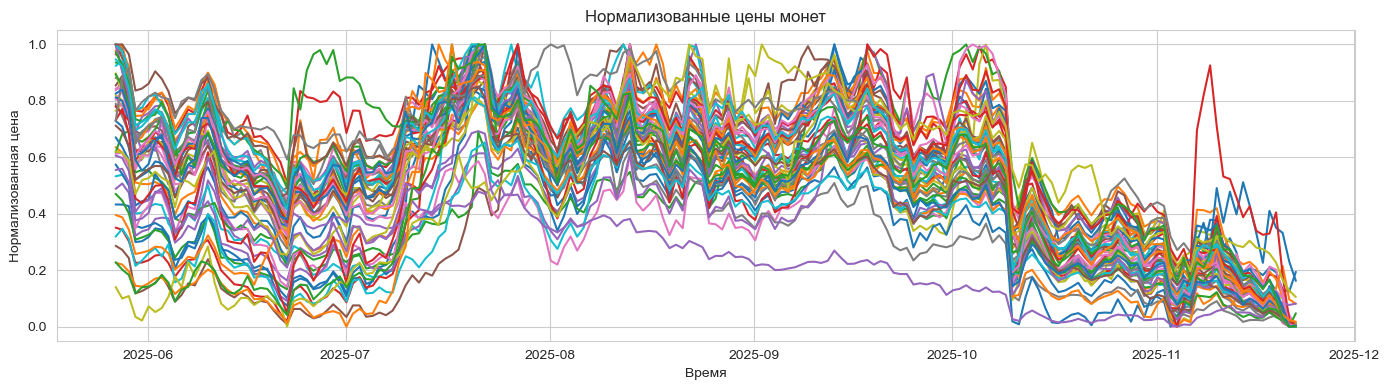

In [23]:
# Нарисуем график с нормализованными ценами
price_cols = [c for c in normed_df.columns if c != 'time']

plt.figure(figsize=(14, 4))
for col in price_cols:
    plt.plot(normed_df['time'].to_list(), normed_df[col].to_list(), label=col)

plt.xlabel("Время")
plt.ylabel("Нормализованная цена")
plt.title("Нормализованные цены монет")
plt.grid(True)
plt.tight_layout()

In [24]:
# Посчитаем евклидово расстояние между парами криптовалют
results = []

# Перебираем все уникальные пары колонок
for col1, col2 in itertools.combinations(price_cols, 2):
    diff_sq = (normed_df[col1] - normed_df[col2]) ** 2
    distance = math.sqrt(diff_sq.sum())
    std = np.std((normed_df[col1] - normed_df[col2]).to_numpy())
    results.append((col1, col2, distance, std))

In [25]:
std_df = pl.DataFrame({"token": list(token_std.keys()), "std_value": list(token_std.values())})
max_dist_df = pl.DataFrame({"token": list(token_dist.keys()), "max_dist": list(token_dist.values())})

In [26]:
dist_df = pl.DataFrame(results, schema=["coin1", "coin2", "dist", "std"], orient="row").sort('dist')
dist_df = dist_df.join(curr_prices, left_on='coin1', right_on='coin').rename({'price': 'price1'})
dist_df = dist_df.join(curr_prices, left_on='coin2', right_on='coin').rename({'price': 'price2'})
dist_df = dist_df.filter(
    (pl.col('price1') / pl.col('price2') < 5) & (pl.col('price1') / pl.col('price2') > 0.2)
)

In [27]:
dist_df = dist_df.join(std_df, left_on="coin1", right_on="token").rename({"std_value": "std_1"})
dist_df = dist_df.join(std_df, left_on="coin2", right_on="token").rename({"std_value": "std_2"})

dist_df = dist_df.join(max_dist_df, left_on="coin1", right_on="token").rename({"max_dist": "dist_1"})
dist_df = dist_df.join(max_dist_df, left_on="coin2", right_on="token").rename({"max_dist": "dist_2"})

In [28]:
dist_df

coin1,coin2,dist,std,price1,price2,std_1,std_2,dist_1,dist_2
str,str,f64,f64,f64,f64,f64,f64,f64,f64
"""GALA""","""VET""",0.438909,0.027199,0.007405,0.01278,0.003064,0.003658,0.012915,0.01562
"""SAND""","""THETA""",0.578317,0.042525,0.1513,0.3458,0.0426,0.14596,0.1943,0.6347
"""PNUT""","""WIF""",0.624965,0.045982,0.08126,0.3321,0.058424,0.205464,0.26024,0.9439
"""STX""","""WIF""",0.745758,0.046008,0.307,0.3321,0.140301,0.205464,0.5965,0.9439
"""BLUR""","""PNUT""",0.759006,0.055729,0.03747,0.08126,0.017223,0.058424,0.07426,0.26024
…,…,…,…,…,…,…,…,…,…
"""ENA""","""MOVE""",5.201519,0.375595,0.2328,0.05413,0.174063,0.035729,0.5767,0.14039
"""ADA""","""NXPC""",5.392424,0.283863,0.4042,0.4442,0.131109,0.335002,0.5564,1.6587
"""NXPC""","""TON""",5.420103,0.177123,0.4442,1.5329,0.335002,0.501093,1.6587,2.0395


In [29]:
# Добавить фичи: скорость возврата к среднему

#### Cointegration approach

In [30]:
ret_cols = [col for col in main_df.columns if '_log_price' in col]
corr_matrix = main_df[ret_cols].corr()

In [31]:
corr_matrix

,1INCH_log_price,ADA_log_price,ALGO_log_price,APT_log_price,ARB_log_price,ARKM_log_price,ATOM_log_price,BLUR_log_price,CELO_log_price,CRV_log_price,...,SUI_log_price,SUSHI_log_price,S_log_price,THETA_log_price,TON_log_price,TRX_log_price,VET_log_price,WIF_log_price,XLM_log_price,XRP_log_price
1INCH_log_price,1.000000,0.773599,0.909699,0.586027,0.777485,0.643777,0.711584,0.619629,0.628757,0.840070,...,0.755284,0.838218,0.453727,0.717500,0.646787,0.549679,0.682967,0.668945,0.859821,0.836256
ADA_log_price,0.773599,1.000000,0.867575,0.636064,0.957756,0.764204,0.765877,0.642502,0.710959,0.859453,...,0.864299,0.863920,0.501498,0.793052,0.730116,0.690670,0.747740,0.648062,0.804866,0.823019
ALGO_log_price,0.909699,0.867575,1.000000,0.634016,0.864275,0.700932,0.778826,0.692297,0.737563,0.936781,...,0.851194,0.921170,0.534254,0.809573,0.741569,0.580765,0.765181,0.730447,0.884954,0.876156
APT_log_price,0.586027,0.636064,0.634016,1.000000,0.641188,0.901424,0.931751,0.904255,0.870678,0.668631,...,0.884663,0.783234,0.907228,0.916660,0.864464,0.035579,0.917443,0.916937,0.327638,0.344833
ARB_log_price,0.777485,0.957756,0.864275,0.641188,1.000000,0.749089,0.800114,0.632039,0.668818,0.843464,...,0.842323,0.884310,0.520180,0.807525,0.767208,0.685621,0.753280,0.676311,0.761830,0.796614
ARKM_log_price,0.643777,0.764204,0.700932,0.901424,0.749089,1.000000,0.933991,0.936739,0.869237,0.720829,...,0.906091,0.832701,0.887266,0.946092,0.832920,0.137078,0.960266,0.903546,0.405037,0.431270
ATOM_log_price,0.711584,0.765877,0.778826,0.931751,0.800114,0.933991,1.000000,0.933204,0.854732,0.808475,...,0.944416,0.913351,0.890326,0.987423,0.937731,0.211115,0.970065,0.956961,0.480603,0.505430
BLUR_log_price,0.619629,0.642502,0.692297,0.904255,0.632039,0.936739,0.933204,1.000000,0.886592,0.738496,...,0.886487,0.837733,0.946381,0.951477,0.860872,-0.017684,0.970399,0.940845,0.350796,0.361445
CELO_log_price,0.628757,0.710959,0.737563,0.870678,0.668818,0.869237,0.854732,0.886592,1.000000,0.744446,...,0.879318,0.808399,0.851493,0.888640,0.783628,0.113551,0.908016,0.834714,0.458535,0.445232
CRV_log_price,0.840070,0.859453,0.936781,0.668631,0.843464,0.720829,0.808475,0.738496,0.744446,1.000000,...,0.875072,0.946685,0.568318,0.838352,0.827078,0.560229,0.785808,0.766022,0.811311,0.817123


In [32]:
stacked = corr_matrix.stack().reset_index()
stacked.columns = ['stock1', 'stock2', 'correlation']

In [33]:
results = []
processed = []
n_rows = 180 # Сколько последних записей учитывать
total = len(list(itertools.combinations(price_cols, 2)))

for col1, col2 in tqdm(itertools.combinations(price_cols, 2), total=total):
    stock1 = col1 + '_log_price'
    stock2 = col2 + '_log_price'
    
    corr_value = pl.DataFrame(stacked).filter(
            (pl.col('stock1') == stock1) & (pl.col('stock2') == stock2)
        ).select('correlation').item()
    

    data = main_df[[stock1, stock2]].dropna()
    data = data[-n_rows:]

    if data.empty:
        print(f"Пара {stock1}-{stock2} пропущена, т.к. нет данных после очистки")
        continue

    adf_stat_1, p_value_1, _ = coint(data[stock1], data[stock2], trend='c')
    adf_stat_2, p_value_2, _ = coint(data[stock2], data[stock1], trend='c')

    beta_1 = np.cov(data[stock1].values, data[stock2].values)[0, 1] / np.var(data[stock1].values)
    beta_2 = np.cov(data[stock2].values, data[stock1].values)[0, 1] / np.var(data[stock2].values)

    results.append({
        'coin1': col1,
        'coin2': col2,
        'corr': corr_value,
        'adf_1': adf_stat_1,
        'pv_1': p_value_1,
        'adf_2': adf_stat_2,
        'pv_2': p_value_2,
        'beta_1': beta_1,
        'beta_2': beta_2
    })

    processed.append((stock1, stock2))

result_df = pd.DataFrame(results)

  0%|          | 0/1378 [00:00<?, ?it/s]

In [37]:
coint_df = pl.DataFrame(result_df)
coint_df

coin1,coin2,corr,adf_1,pv_1,adf_2,pv_2,beta_1,beta_2
str,str,f64,f64,f64,f64,f64,f64,f64
"""1INCH""","""ADA""",0.773599,-2.403797,0.323059,-0.998953,0.903046,1.674146,0.365034
"""1INCH""","""ALGO""",0.909699,-2.957515,0.120653,-2.315986,0.365604,0.8252,1.026636
"""1INCH""","""APT""",0.586027,-2.417775,0.316483,-0.917935,0.917339,2.615772,0.151214
"""1INCH""","""ARB""",0.777485,-2.924099,0.129367,-1.29052,0.832578,1.41865,0.431797
"""1INCH""","""ARKM""",0.643777,-2.88542,0.140012,-1.576786,0.730588,1.413249,0.38151
…,…,…,…,…,…,…,…,…
"""VET""","""XLM""",0.435679,-1.544991,0.743539,-2.173253,0.438196,9.198607,0.041024
"""VET""","""XRP""",0.453715,-1.766198,0.645991,-2.173499,0.438068,19.568934,0.020609
"""WIF""","""XLM""",0.412523,-0.759328,0.939843,-2.126119,0.462724,0.231524,1.138642


In [38]:
pair_stats_df = dist_df.drop('price1', 'price2').join(coint_df, on=['coin1', 'coin2'], how='left')
pair_stats_df = pair_stats_df.filter(
   # (pl.col('pv_1') < 0.05) & (pl.col('pv_2') < 0.05) & 
    (pl.col('dist') > 0.8) & (pl.col('dist') < 1.8) & (abs(pl.col('beta_1') - pl.col('beta_2')) < 1.5)
).rename({'dist': 'spr_dist', 'std': 'spr_std'}).drop('adf_1', 'adf_2')

In [39]:
pair_stats_df

coin1,coin2,spr_dist,spr_std,std_1,std_2,dist_1,dist_2,corr,pv_1,pv_2,beta_1,beta_2
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""PNUT""","""STX""",0.805981,0.055185,0.058424,0.140301,0.26024,0.5965,0.975707,0.003477,0.007637,1.785516,0.538277
"""GRT""","""KAS""",0.824004,0.050257,0.015322,0.016726,0.06704,0.07653,0.978755,0.001486,0.002487,1.080535,0.891489
"""DYDX""","""OP""",0.856954,0.059417,0.13283,0.138938,0.5019,0.5708,0.976915,0.423556,0.382516,0.958982,1.007533
"""INJ""","""SUI""",0.871644,0.06233,2.589654,0.641119,10.828,2.984,0.958635,0.145895,0.266312,0.72385,1.319166
"""SUI""","""THETA""",0.884407,0.060559,0.641119,0.14596,2.984,0.6347,0.962532,0.289508,0.129554,0.506667,1.858679
…,…,…,…,…,…,…,…,…,…,…,…,…
"""EGLD""","""TON""",1.766593,0.085846,2.585123,0.501093,10.816,2.0395,0.916855,0.000366,0.002251,0.68315,1.350722
"""STX""","""SUI""",1.768671,0.108669,0.140301,0.641119,0.5965,2.984,0.881671,0.392959,0.857083,1.714629,0.469938
"""ARKM""","""MANTA""",1.775858,0.101385,0.10068,0.048751,0.4519,0.2157,0.927675,0.838117,0.705265,0.542513,1.517853


In [ ]:
# Проверка, есть ли такая пара в нашей выборке
token_1 = 'ARKM'
token_2 = 'OP'
pair_stats_df.filter(
    ((pl.col('coin1') == token_1) & (pl.col('coin2') == token_2)) | 
    ((pl.col('coin2') == token_1) & (pl.col('coin1') == token_2))
)

In [40]:
pair_stats_df.write_parquet('./data/pair_selection/curr_pairs.parquet')

In [ ]:
# pair_stats_df = pl.read_parquet('./data/pair_selection/curr_pairs.parquet')

In [ ]:
pair_stats_df.filter(
    ((pl.col('coin1') == 'CELO') & (pl.col('coin2') == 'POL')) | 
    ((pl.col('coin1') == 'SEI') & (pl.col('coin2') == 'DYDX'))   |
    ((pl.col('coin1') == 'IOTA') & (pl.col('coin2') == 'MANA'))   |
    ((pl.col('coin1') == 'FLOW') & (pl.col('coin2') == 'MANTA'))    
)

In [41]:
pairs = db_manager.get_table('pairs', df_type='polars')

In [42]:
token_list = []

for row in pair_stats_df.iter_rows(named=True):
    t1 = row["coin1"]
    t2 = row["coin2"]

    if (t1, t2) not in token_list and (t2, t1) not in token_list:
        token_list.append((t1, t2))
len(token_list)

112

In [43]:
for row in pairs.iter_rows(named=True):
    t1 = row['token_1'][:-5]
    t2 = row['token_2'][:-5]
    
    if (t1, t2) not in token_list and (t2, t1) not in token_list:
        token_list.append((t1, t2))
        print((t1, t2))

('IOTA', 'SAND')
('XRP', 'LDO')
('STX', 'WIF')


In [44]:
token_list

[('PNUT', 'STX'),
 ('GRT', 'KAS'),
 ('DYDX', 'OP'),
 ('INJ', 'SUI'),
 ('SUI', 'THETA'),
 ('ATOM', 'EGLD'),
 ('BLUR', 'GRT'),
 ('FLOW', 'SAND'),
 ('ARKM', 'SAND'),
 ('PNUT', 'S'),
 ('MANA', 'SAND'),
 ('GMT', 'GRT'),
 ('DYDX', 'THETA'),
 ('OP', 'THETA'),
 ('CRV', 'SUSHI'),
 ('ONDO', 'THETA'),
 ('ONDO', 'OP'),
 ('ETHFI', 'IMX'),
 ('HBAR', 'XLM'),
 ('JUP', 'SAND'),
 ('BLUR', 'GMT'),
 ('JUP', 'THETA'),
 ('MANTA', 'PNUT'),
 ('DRIFT', 'IMX'),
 ('ARKM', 'OP'),
 ('STX', 'S'),
 ('RUNE', 'WIF'),
 ('EGLD', 'INJ'),
 ('OP', 'SUI'),
 ('JUP', 'ONDO'),
 ('ATOM', 'SUI'),
 ('ARKM', 'THETA'),
 ('DOT', 'INJ'),
 ('ADA', 'ONDO'),
 ('ARKM', 'JUP'),
 ('DOT', 'SUI'),
 ('ALGO', 'HBAR'),
 ('1INCH', 'ALGO'),
 ('STX', 'THETA'),
 ('GMT', 'KAS'),
 ('FARTCOIN', 'RUNE'),
 ('RUNE', 'STX'),
 ('DRIFT', 'ETHFI'),
 ('S', 'WIF'),
 ('ATOM', 'DOT'),
 ('ARKM', 'FLOW'),
 ('MOVE', 'S'),
 ('ALGO', 'XLM'),
 ('MANTA', 'S'),
 ('ARKM', 'ONDO'),
 ('JUP', 'MANA'),
 ('ARKM', 'PNUT'),
 ('MANA', 'POL'),
 ('DOT', 'ONDO'),
 ('THETA', 'WIF'),

In [45]:
with open('./data/token_pairs.txt', 'w') as file:
    for pair in token_list:
        file.write(f"{pair[0]} {pair[1]}\n")

In [ ]:
main_df[[stock1, stock2]].mean()

In [ ]:
import scipy as sc
from statsmodels.graphics.tsaplots import plot_acf

In [ ]:
log_returns = main_df['XRP_log_returns']

In [ ]:
log_returns.plot(figsize=(12,3));

In [ ]:
plot_acf(log_returns);

In [ ]:
log_returns_sq = np.square(log_returns)
log_returns_sq.plot(figsize=(12,3));

In [ ]:
plot_acf(log_returns_sq);

In [ ]:
volatility = log_returns.rolling(window=30).std()*np.sqrt(195)
volatility = volatility.dropna()
volatility.plot(figsize=(12,3));

In [ ]:
import numpy as np
from scipy import stats, optimize

# данные (как у вас)
mu = 5
sigma = 2.5
N = 10000
np.random.seed(1)
x = np.random.normal(loc=mu, scale=sigma, size=N)

def neg_log_lik(theta, x):
    mu_hat, sigma_hat = theta
    if sigma_hat <= 0:
        return 1e20
    return -np.sum(stats.norm.logpdf(x, loc=mu_hat, scale=sigma_hat))

theta0 = [2.0, 3.0]
bounds = [(None, None), (1e-8, None)]   # второе — sigma >= tiny positive

res = optimize.minimize(neg_log_lik, theta0, args=(x,), method='L-BFGS-B', bounds=bounds)
mu_hat, sigma_hat = res.x
print("mu_hat =", mu_hat, "sigma_hat =", sigma_hat)


In [ ]:
import numpy as np
from scipy import stats, optimize

# ---------- симуляция OU ----------
def simulate_ou(kappa, mu, sigma, x0, delta, n_steps, seed=0):
    np.random.seed(seed)
    xs = np.empty(n_steps + 1)
    xs[0] = x0
    phi = np.exp(-kappa * delta)
    var_incr = (sigma**2 / (2 * kappa)) * (1 - np.exp(-2 * kappa * delta))
    for i in range(n_steps):
        mean = mu + (xs[i] - mu) * phi
        xs[i+1] = mean + np.random.normal(scale=np.sqrt(var_incr))
    return xs

# Параметры "истинные"
kappa_true = 1.2
mu_true = 2.5
sigma_true = 0.2
delta = 0.1
n_steps = 2000

x = simulate_ou(kappa_true, mu_true, sigma_true, x0=0.0, delta=delta, n_steps=n_steps, seed=42)

In [ ]:
plt.plot(x);

In [ ]:
spread = (main_df['XRP_log_price'] - main_df['XLM_log_price']).values
spread.mean(), spread.std()

In [ ]:
# ---------- Метод A: регрессия (AR(1)) ----------
X_t = spread[:-1]
X_tp1 = spread[1:]
# регрессия с константой: X_tp1 = a + phi * X_t + eps
# построим OLS вручную
n = len(X_t)
X_design = np.column_stack([np.ones(n), X_t])
beta_hat = np.linalg.lstsq(X_design, X_tp1, rcond=None)[0]  # [a_hat, phi_hat]
a_hat, phi_hat = beta_hat[0], beta_hat[1]
mu_hat_reg = a_hat / (1 - phi_hat)
kappa_hat_reg = -np.log(phi_hat) / delta
residuals = X_tp1 - (a_hat + phi_hat * X_t)
var_res = np.mean(residuals**2)  # MLE uses 1/n (not 1/(n-1))
sigma_hat_reg = np.sqrt( 2 * kappa_hat_reg * var_res / (1 - phi_hat**2) )

print("REGRESSION ESTIMATES:")
print("mu_hat =", mu_hat_reg, "kappa_hat =", kappa_hat_reg, "sigma_hat =", sigma_hat_reg)

In [ ]:
# ---------- Метод B: MLE (оптимизация) ----------
# Негативное лог-правдоподобие, оптимизируем по (log_kappa, mu, log_sigma)
def neg_log_lik_reparam(params, X, delta):
    log_kappa, mu, log_sigma = params
    kappa = np.exp(log_kappa)
    sigma = np.exp(log_sigma)
    phi = np.exp(-kappa * delta)
    # переходные mean и var
    means = mu + (X[:-1] - mu) * phi
    vars_ = (sigma**2 / (2 * kappa)) * (1 - np.exp(-2 * kappa * delta))
    # защита: если какие-то vars_ численно ноль или отрицательны, вернуть большой штраф
    if np.any(vars_ <= 0) or kappa <= 0 or sigma <= 0:
        return 1e30
    # суммируем отрицательные лог-плотности
    nll = -np.sum(stats.norm.logpdf(X[1:], loc=means, scale=np.sqrt(vars_)))
    return nll

In [ ]:
# начальные приближения: можно взять из регрессии
init = [np.log(max(kappa_hat_reg, 1e-6)), mu_hat_reg, np.log(max(sigma_hat_reg, 1e-6))]
res = optimize.minimize(neg_log_lik_reparam, x0=init, args=(spread, delta),
                        method='L-BFGS-B')  # можно и без bounds, т.к. reparam
if not res.success:
    print("Optimization warning:", res.message)

log_kappa_hat, mu_hat_mle, log_sigma_hat = res.x
kappa_hat_mle = np.exp(log_kappa_hat)
sigma_hat_mle = np.exp(log_sigma_hat)

print("\nMLE ESTIMATES:")
print("mu_hat =", mu_hat_mle, "kappa_hat =", kappa_hat_mle, "sigma_hat =", sigma_hat_mle)

In [ ]:
half_life = np.log(2) / kappa_hat_mle  # в часах
print(f"Время полураспада: {half_life:.2f} часов")

In [ ]:
x = np.array(volatility)

In [ ]:
import numpy as np
from scipy.optimize import minimize

# Функция для оценки параметров OU
def ou_ll(params, data):
    theta, mu, sigma = params
    n = len(data)
    dt = 1  # assuming hourly data (time step = 1 hour)
    pred = data[:-1] + theta * (mu - data[:-1]) * dt
    var = sigma**2 * dt
    log_likelihood = -0.5 * (n-1) * np.log(2 * np.pi * var) - np.sum((data[1:] - pred)**2) / (2 * var)
    return -log_likelihood  # минимизируем отрицательное правдоподобие

# Начальные guess параметров
initial_guess = [0.1, np.mean(spread), np.std(spread)]
result = minimize(ou_ll, initial_guess, args=(spread,), method='L-BFGS-B', 
                 bounds=[(1e-6, None), (None, None), (1e-6, None)])

theta_est, mu_est, sigma_est = result.x
print(f"Скорость возврата θ: {theta_est:.4f}")

In [ ]:
mu_est, theta_est, sigma_est

In [ ]:
half_life = np.log(2) / theta_est  # в часах
print(f"Время полураспада: {half_life:.2f} часов")